### Workflow for predicting TFs to perturb for a specific transition

In [1]:
import sys
import numpy as np
import pandas as pd
sys.path.append('../model/')

%load_ext autoreload
%autoreload 2

from precice import precice
from plot import make_bar_plot, make_error_plot
import scanpy as sc

/dfs/user/yhr/uce/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0. Read in and set up data

In [2]:
raw_adata = sc.read_h5ad('../data/Friedman.h5ad')
path = '../data/Friedman.h5ad'

In [3]:
workflow = precice(adata=raw_adata, path = path, cell_filter=True)

Loading preprocessed data...


In [4]:
workflow.adata

AnnData object with n_obs × n_vars = 11577 × 2067
    obs: 'day', 'label', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
    layers: 'counts'

### 1. Run batch effect correction (if needed)

In [5]:
## Run batch effect correction

workflow.set_up_scvi(batch_key='day')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/dfs/user/yhr/uce/lib/python3.10/site-p

Epoch 351/400:  88%|▉| 351/400 [09:50<01:22,  1.68s/it, v_num=1, train_loss_step
Monitored metric elbo_validation did not improve in the last 20 records. Best score: 944.472. Signaling Trainer to stop.


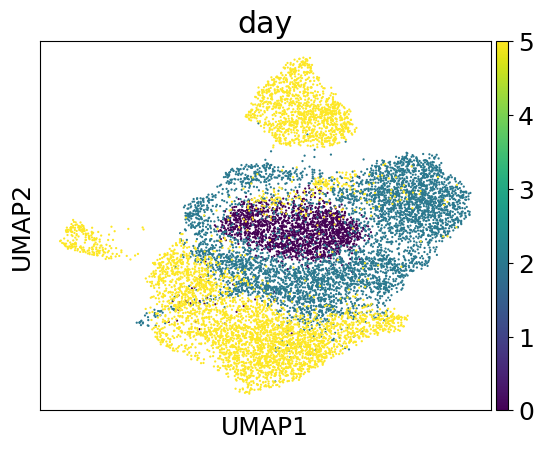

In [6]:
## Visualize effects

workflow.scvi_plot_setup()
sc.pl.umap(workflow.adata, color='day')

In [7]:
##adata_reduced = sc.read_h5ad('/dfs/user/yhr/cell_reprogram/Notebooks/workflow_dir/Friedman_reduced.h5ad')

### Using cell type labels

In [8]:
source_target_pairs = [['stem', 'meso'], 
                       ['stem', 'endo'], 
                       ['endo', 'meso'],
                       ['meso', 'endo']]

for source_name, target_name in source_target_pairs:
    workflow.get_DE(source_name=source_name, target_name=target_name)

DE...: 100%|██████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


In [9]:
## Save differential expression output

workflow.write_DE_files(DE_dir='../data/')

../data/DE_Friedman_stem_to_meso.csv
../data/DE_Friedman_stem_to_endo.csv
../data/DE_Friedman_endo_to_meso.csv
../data/DE_Friedman_meso_to_endo.csv


### Read in (or infer) network

In [10]:
## TODO add a dropdown or something here which allows users to pick their cell type of interest
workflow.get_network(cell_type='embryonic stem cell')

Network path loaded


### Run PRECICE

In [11]:
# -----------

for source_name, target_name in source_target_pairs:
    print(source_name, target_name)
    transition = source_name +'_to_' + target_name
    python_path = '/dfs/user/yhr/uce/bin/python'
    workflow.run_precice(species='human', python_path=python_path,
                          network_path=workflow.network_path,
                          DE_path=workflow.DE_filenames[transition])

stem meso
Running command: /dfs/user/yhr/uce/bin/python ../model/run_precice.py --p_thresh 2e-2 --hops 3 --species human --adjacency ./data/networks/embryonic_stem_cells_meso_endo_Friedman_1_linearweights.csv --DE_data ../data/DE_Friedman_stem_to_meso.csv


Traceback (most recent call last):
  File "/dfs/user/yhr/snap/precice/notebooks/../model/run_precice.py", line 356, in <module>
    f = flow_model(args)
  File "/dfs/user/yhr/snap/precice/notebooks/../model/run_precice.py", line 54, in __init__
    self.read_weights = pd.read_csv(args.adjacency, index_col=0)
  File "/dfs/user/yhr/uce/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/dfs/user/yhr/uce/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 620, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/dfs/user/yhr/uce/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1620, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "/dfs/user/yhr/uce/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1880, in _make_engine
    self.handles = get_handle(
  File "/dfs/user/yhr/uce/lib/python3.10/site-packages/pandas/io/common

no_parallel_p_0.02_max_step_1_hops_3_DE_DE_Friedman_stem_to_meso_adjacency_embryonic_stem_cells_meso_endo_Friedman_1_linearweights
stem endo
Running command: /dfs/user/yhr/uce/bin/python ../model/run_precice.py --p_thresh 2e-2 --hops 3 --species human --adjacency ./data/networks/embryonic_stem_cells_meso_endo_Friedman_1_linearweights.csv --DE_data ../data/DE_Friedman_stem_to_endo.csv
no_parallel_p_0.02_max_step_1_hops_3_DE_DE_Friedman_stem_to_endo_adjacency_embryonic_stem_cells_meso_endo_Friedman_1_linearweights
endo meso
Running command: /dfs/user/yhr/uce/bin/python ../model/run_precice.py --p_thresh 2e-2 --hops 3 --species human --adjacency ./data/networks/embryonic_stem_cells_meso_endo_Friedman_1_linearweights.csv --DE_data ../data/DE_Friedman_endo_to_meso.csv


Traceback (most recent call last):
  File "/dfs/user/yhr/snap/precice/notebooks/../model/run_precice.py", line 356, in <module>
    f = flow_model(args)
  File "/dfs/user/yhr/snap/precice/notebooks/../model/run_precice.py", line 54, in __init__
    self.read_weights = pd.read_csv(args.adjacency, index_col=0)
  File "/dfs/user/yhr/uce/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/dfs/user/yhr/uce/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 620, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/dfs/user/yhr/uce/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1620, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "/dfs/user/yhr/uce/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1880, in _make_engine
    self.handles = get_handle(
  File "/dfs/user/yhr/uce/lib/python3.10/site-packages/pandas/io/common

no_parallel_p_0.02_max_step_1_hops_3_DE_DE_Friedman_endo_to_meso_adjacency_embryonic_stem_cells_meso_endo_Friedman_1_linearweights
meso endo
Running command: /dfs/user/yhr/uce/bin/python ../model/run_precice.py --p_thresh 2e-2 --hops 3 --species human --adjacency ./data/networks/embryonic_stem_cells_meso_endo_Friedman_1_linearweights.csv --DE_data ../data/DE_Friedman_meso_to_endo.csv


Traceback (most recent call last):
  File "/dfs/user/yhr/snap/precice/notebooks/../model/run_precice.py", line 356, in <module>
    f = flow_model(args)
  File "/dfs/user/yhr/snap/precice/notebooks/../model/run_precice.py", line 54, in __init__
    self.read_weights = pd.read_csv(args.adjacency, index_col=0)
  File "/dfs/user/yhr/uce/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/dfs/user/yhr/uce/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 620, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/dfs/user/yhr/uce/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1620, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "/dfs/user/yhr/uce/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1880, in _make_engine
    self.handles = get_handle(
  File "/dfs/user/yhr/uce/lib/python3.10/site-packages/pandas/io/common

no_parallel_p_0.02_max_step_1_hops_3_DE_DE_Friedman_meso_to_endo_adjacency_embryonic_stem_cells_meso_endo_Friedman_1_linearweights


In [12]:
workflow.network_path

'./data/networks/embryonic_stem_cells_meso_endo_Friedman_1_linearweights.csv'